In [ ]:
import pandas as pd
import json
import re
import time
from pathlib import Path
from collections import Counter
from tqdm import tqdm

tqdm.pandas()
print("Setup selesai")


Setup selesai


In [ ]:
INPUT_FILE = "../data/transcript/metadata_labeled.json"
OUTPUT_DIR = "normalization"
Path(OUTPUT_DIR).mkdir(exist_ok=True)

print("Loading data...")
start_time = time.time()

df = pd.read_json(INPUT_FILE, encoding='utf-8')
print(f"Data berhasil di-load: {len(df)} sampel")
print(f"Kolom tersedia: {list(df.columns)}")
print(f"Load time: {time.time() - start_time:.2f} detik")


Loading data...
Data berhasil di-load: 1000 sampel
Kolom tersedia: ['sample_id', 'source', 'keyword', 'video_id', 'title', 'channel', 'duration', 'upload_date', 'url', 'audio_path', 'thumbnail_path', 'transcript_path', 'transcript_text', 'transcript_length', 'language', 'label', 'status', 'transcribed_at', 'keyword_tier', 'channel_type']
Load time: 0.08 detik


In [ ]:
print("=" * 60)
print("TAHAP 1: ENHANCED CLEANING")
print("=" * 60)

df['cleaned_text'] = df['transcript_text'].astype(str)

def clean_text(text):
    text = re.sub(r'(\.\s*){3,}', ' [PAUSE] ', text)
    text = re.sub(r'\.{4,}', ' [PAUSE] ', text)
    text = re.sub(r'\[\d{1,2}:\d{2}(:\d{2})?\]', '', text)
    text = re.sub(r'\[music\]|\[applause\]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['cleaned_text'].progress_apply(clean_text)
print("Cleaning selesai")


TAHAP 1: ENHANCED CLEANING


100%|██████████| 1000/1000 [00:00<00:00, 2291.62it/s]

Cleaning selesai


In [ ]:
print("=" * 60)
print("TAHAP 2: NORMALISASI KATA + CASE FOLDING")
print("=" * 60)

normalization_dict = {
    r'\bprabuhu\b': 'prabowo',
    r'\bgiberan\b': 'gibran',
    r'\bmemeliki\b': 'memiliki',
    r'\bcolaborasi\b': 'kolaborasi',
    r'\bgak\b': 'tidak',
    r'\byg\b': 'yang',
    r'\bdgn\b': 'dengan',
    r'\butk\b': 'untuk',
    r'\bdr\b': 'dari',
    r'\bklo\b': 'kalau',
    r'\bknp\b': 'kenapa',
    r'\bkyk\b': 'seperti',
    r'\bbgt\b': 'banget',
    r'\baja\b': 'saja'
}

def normalize_text(text):
    text = text.lower()
    for pattern, repl in normalization_dict.items():
        text = re.sub(pattern, repl, text)
    return text

df['normalized_text'] = df['cleaned_text'].progress_apply(normalize_text)
print("Normalisasi selesai")


TAHAP 2: NORMALISASI KATA + CASE FOLDING


100%|██████████| 1000/1000 [00:00<00:00, 1266.54it/s]

Normalisasi selesai


In [ ]:
print("=" * 60)
print("TAHAP 3: QUALITY CHECK & FILTERING")
print("=" * 60)

df['token_count'] = df['normalized_text'].apply(lambda x: len(str(x).split()))
MIN_LENGTH = 50
MIN_TOKENS = 10

df['quality_status'] = 'GOOD'
df.loc[df['normalized_text'].str.len() < MIN_LENGTH, 'quality_status'] = 'BAD'
df.loc[df['token_count'] < MIN_TOKENS, 'quality_status'] = 'BAD'
df.loc[df['normalized_text'].isna() | (df['normalized_text'].str.strip() == ''), 'quality_status'] = 'BAD'

def has_high_repetition(text):
    words = str(text).split()
    if len(words) < 10:
        return False
    counts = Counter(words)
    return counts.most_common(1)[0][1] / len(words) > 0.3

df['repetition_flag'] = df['normalized_text'].apply(has_high_repetition)
df.loc[df['repetition_flag'] & (df['quality_status'] == 'GOOD'), 'quality_status'] = 'WARNING'

print("SUMMARY:")
print(df['quality_status'].value_counts())

df_good = df[df['quality_status'] == 'GOOD'].copy()
print(f"Filtered dataset: {len(df_good)} samples siap untuk modeling")


TAHAP 3: QUALITY CHECK & FILTERING
SUMMARY:
quality_status
GOOD       992
BAD          7
WARNING      1
Name: count, dtype: int64
Filtered dataset: 992 samples siap untuk modeling


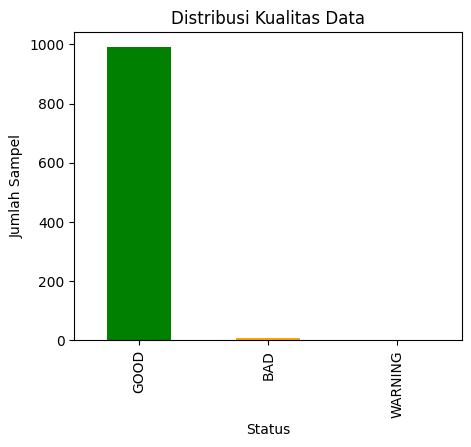

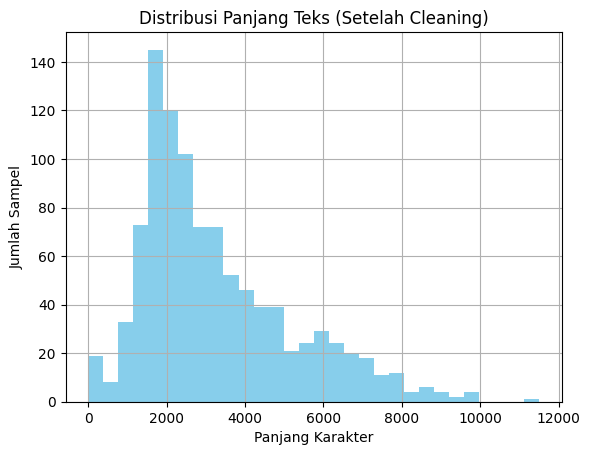

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
df['quality_status'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribusi Kualitas Data')
plt.xlabel('Status')
plt.ylabel('Jumlah Sampel')
plt.show()

df['normalized_text'].str.len().hist(bins=30, color='skyblue')
plt.title('Distribusi Panjang Teks (Setelah Cleaning)')
plt.xlabel('Panjang Karakter')
plt.ylabel('Jumlah Sampel')
plt.show()


In [ ]:
df_good.to_json(f"{OUTPUT_DIR}/final_metadata_clean.json", orient="records", force_ascii=False, indent=2)
print("Dataset akhir disimpan di:", f"{OUTPUT_DIR}/final_metadata_clean.json")

Dataset akhir disimpan di: normalized_results/final_metadata_clean.json
